In [1]:
# =====================================
# ENERGY EFFICIENCY PREDICTION PROJECT
# =====================================

# Install required packages if you have not done so!
# pip install xgboost scikit-learn seaborn matplotlib pandas numpy joblib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

# -------------------------------
# 1. LOAD DATA
# -------------------------------

file_path = r"ENB2012_data.csv"
df = pd.read_csv(file_path)

print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (768, 10)


,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [2]:
# Rename columns for clarity
df.columns = [
    "Relative_Compactness",
    "Surface_Area",
    "Wall_Area",
    "Roof_Area",
    "Overall_Height",
    "Orientation",
    "Glazing_Area",
    "Glazing_Area_Distribution",
    "Heating_Load",
    "Cooling_Load"
]


# Check for missing values
print(df.isnull().sum())

# Feature matrix (X) and target (y)
X = df.drop(["Heating_Load", "Cooling_Load"], axis=1)

# We will model HEATING LOAD first (you can duplicate for cooling)
y = df["Heating_Load"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Relative_Compactness         0
Surface_Area                 0
Wall_Area                    0
Roof_Area                    0
Overall_Height               0
Orientation                  0
Glazing_Area                 0
Glazing_Area_Distribution    0
Heating_Load                 0
Cooling_Load                 0
dtype: int64
Train size: (614, 8)
Test size: (154, 8)


In [3]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


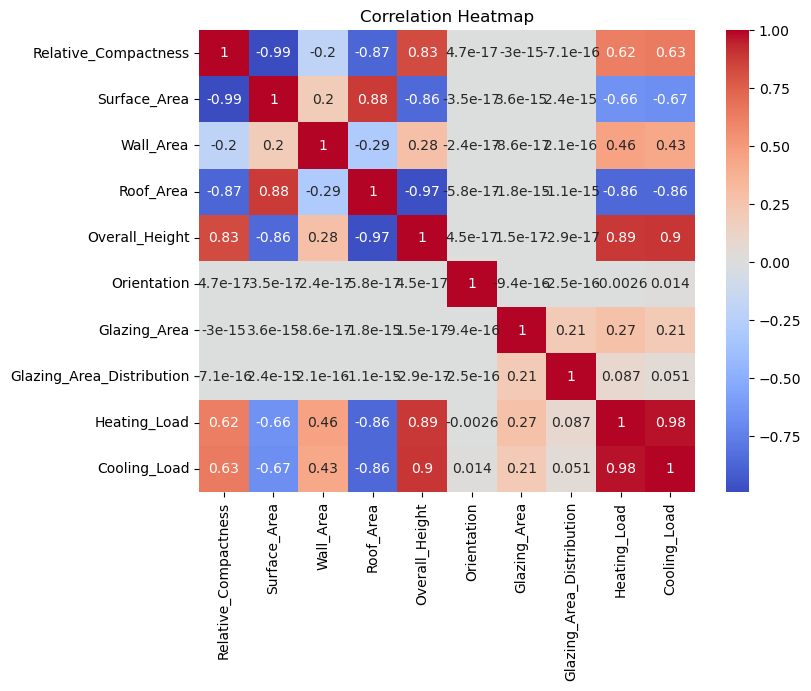

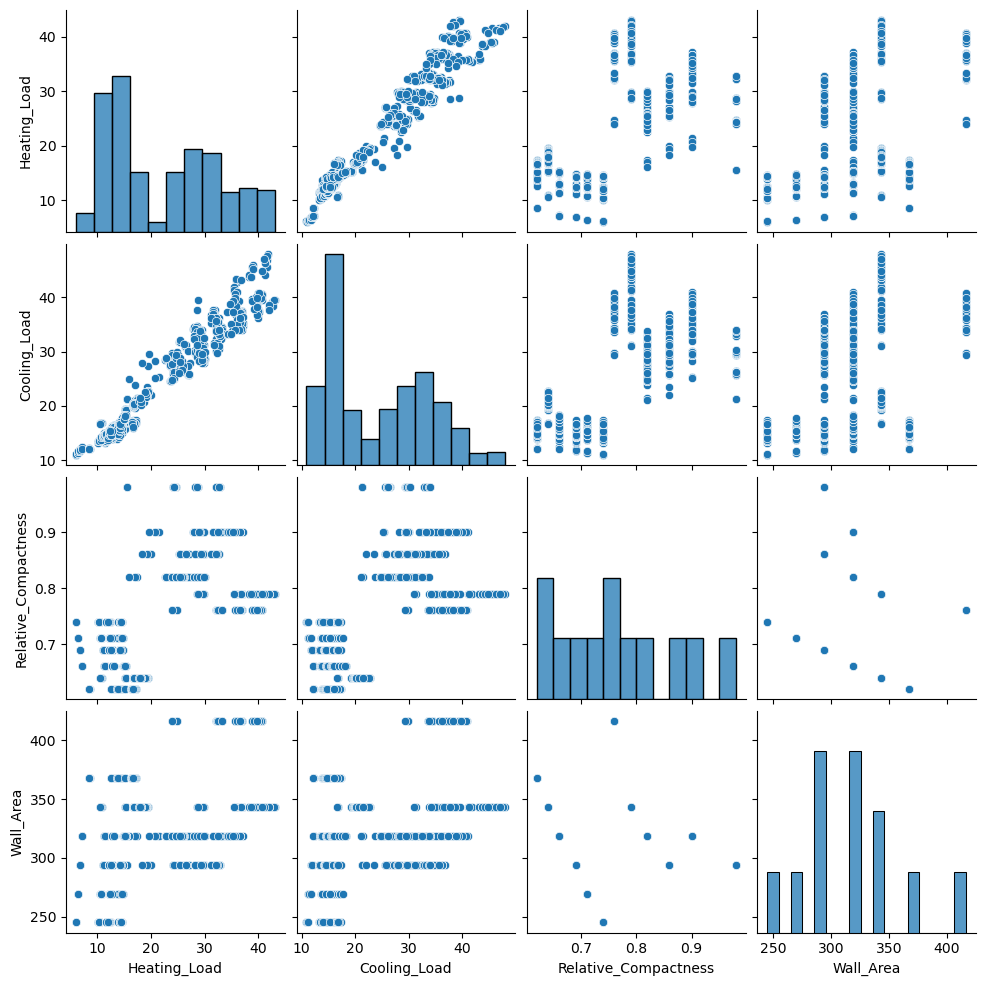

In [4]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

sns.pairplot(df[["Heating_Load", "Cooling_Load", "Relative_Compactness", "Wall_Area"]])
plt.show()


In [5]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)

print("Linear Regression R2:", r2_score(y_test, lr_pred))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, lr_pred)))


Linear Regression R2: 0.9121840951546909
Linear Regression RMSE: 3.0254235827736187


In [6]:
rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print("Random Forest R2:", r2_score(y_test, rf_pred))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, rf_pred)))


Random Forest R2: 0.9977231861442363
Random Forest RMSE: 0.48715073302922335


In [7]:
xg = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

xg.fit(X_train, y_train)
xg_pred = xg.predict(X_test)

print("XGBoost R2:", r2_score(y_test, xg_pred))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, xg_pred)))


XGBoost R2: 0.9984514149552068
XGBoost RMSE: 0.4017604001726565


In [8]:
mlp = MLPRegressor(
    hidden_layer_sizes=(64, 64),
    max_iter=1500,
    activation='relu',
    solver='adam',
    random_state=42
)

mlp.fit(X_train_scaled, y_train)
mlp_pred = mlp.predict(X_test_scaled)

print("MLP R2:", r2_score(y_test, mlp_pred))
print("MLP RMSE:", np.sqrt(mean_squared_error(y_test, mlp_pred)))


MLP R2: 0.9962522847047356
MLP RMSE: 0.6250041386003562


In [9]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "XGBoost", "MLP Neural Network"],
    "R2 Score": [
        r2_score(y_test, lr_pred),
        r2_score(y_test, rf_pred),
        r2_score(y_test, xg_pred),
        r2_score(y_test, mlp_pred)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, lr_pred)),
        np.sqrt(mean_squared_error(y_test, rf_pred)),
        np.sqrt(mean_squared_error(y_test, xg_pred)),
        np.sqrt(mean_squared_error(y_test, mlp_pred))
    ]
})

results


,Model,R2 Score,RMSE
0,Linear Regression,0.912184,3.025424
1,Random Forest,0.997723,0.487151
2,XGBoost,0.998451,0.401760
3,MLP Neural Network,0.996252,0.625004


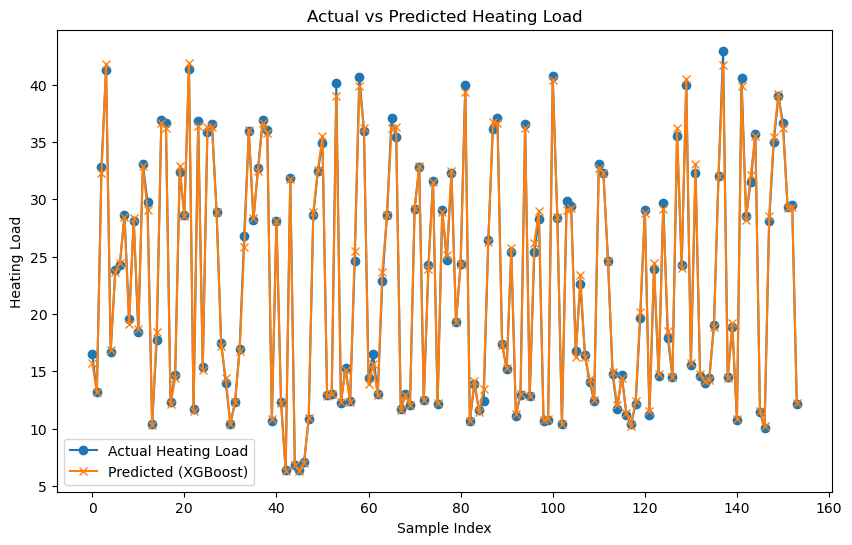

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="Actual Heating Load", marker='o')
plt.plot(xg_pred, label="Predicted (XGBoost)", marker='x')
plt.title("Actual vs Predicted Heating Load")
plt.xlabel("Sample Index")
plt.ylabel("Heating Load")
plt.legend()
plt.show()


In [11]:
# =====================================
    # 5. ANALYSIS FOR COOLING LOAD (Y2)
    # =====================================
    
print("\n--- Starting Cooling Load (Y2) Analysis ---")
    
    # 1. Redefine Target Variable (Y2)
    # We use new variable names (y_cool, X_train_cool, etc.) to keep the Heating Load data separate.
y_cool = df["Cooling_Load"] 
    
    # 2. Re-split Data with the new target
X_train_cool, X_test_cool, y_train_cool, y_test_cool = train_test_split(
    X, y_cool, test_size=0.2, random_state=42
    )
    
    # 3. Re-scale Features (using the original fitted scaler)
X_train_scaled_cool = scaler.transform(X_train_cool)
X_test_scaled_cool = scaler.transform(X_test_cool)


--- Starting Cooling Load (Y2) Analysis ---


In [12]:
# --- MODEL RE-TRAINING AND PREDICTION ---
    
    # Linear Regression (on scaled data)
lr.fit(X_train_scaled_cool, y_train_cool)
lr_pred_cool = lr.predict(X_test_scaled_cool)
    
    # Random Forest (on unscaled data)
rf.fit(X_train_cool, y_train_cool)
rf_pred_cool = rf.predict(X_test_cool)
    
    # XGBoost (on unscaled data)
xg.fit(X_train_cool, y_train_cool)
xg_pred_cool = xg.predict(X_test_cool)
    
    # MLP Neural Network (on scaled data - max_iter is already 1500)
mlp.fit(X_train_scaled_cool, y_train_cool)
mlp_pred_cool = mlp.predict(X_test_scaled_cool)


Cooling Load (Y2) Model Comparison:
                Model  R2 Score      RMSE
0             XGBoost  0.987590  1.072314
1  MLP Neural Network  0.982668  1.267243
2       Random Forest  0.966782  1.754402
3   Linear Regression  0.893226  3.145382


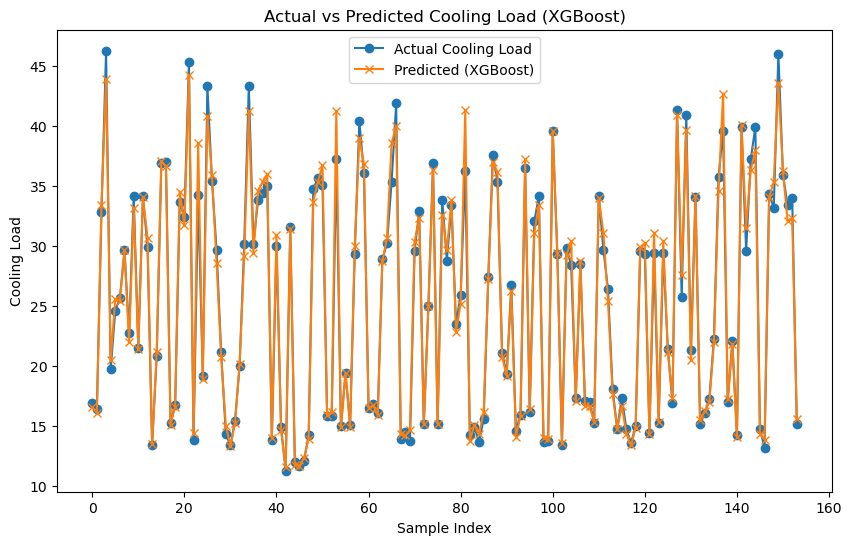

In [13]:
models = ["Linear Regression", "Random Forest", "XGBoost", "MLP Neural Network"]
predictions_cool = [lr_pred_cool, rf_pred_cool, xg_pred_cool, mlp_pred_cool]
    
results_cool = []
for model, pred in zip(models, predictions_cool):
    r2 = r2_score(y_test_cool, pred)
    rmse = np.sqrt(mean_squared_error(y_test_cool, pred))
    results_cool.append({"Model": model, "R2 Score": r2, "RMSE": rmse})
    
df_results_cool = pd.DataFrame(results_cool)
df_results_cool = df_results_cool.sort_values(by="R2 Score", ascending=False).reset_index(drop=True)
    
print("\nCooling Load (Y2) Model Comparison:")
print(df_results_cool)
    
    # 6. Visualization (Cooling Load - using the best model)
plt.figure(figsize=(10, 6))
plt.plot(y_test_cool.values, label="Actual Cooling Load", marker='o')
plt.plot(xg_pred_cool, label="Predicted (XGBoost)", marker='x')
plt.title("Actual vs Predicted Cooling Load (XGBoost)")
plt.xlabel("Sample Index")
plt.ylabel("Cooling Load")
plt.legend()
plt.show()

In [14]:


# =====================================
# 6. MODEL EXPORT (FOR WEBSITE DEPLOYMENT NOT IMPORTANT FOR SHOWCASE)
# =====================================
    
# --- Heating Load Model (Y1) ---
    
# Re-train the XGBoost model specifically for the Heating Load (using the original split)
# This ensures we save the final version optimized for Y1
X = df.drop(["Heating_Load", "Cooling_Load"], axis=1)
y = df["Heating_Load"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
xg.fit(X_train, y_train)
joblib.dump(xg, 'xgboost_heating_load_model.pkl')
print("XGBoost (Heating Load) saved to 'xgboost_heating_load_model.pkl'")
    
# --- Cooling Load Model (Y2) ---
    
# Re-train the XGBoost model specifically for the Cooling Load (using the cool split variables)
# This ensures we save the final version optimized for Y2
y_cool = df["Cooling_Load"] 
X_train_cool, X_test_cool, y_train_cool, y_test_cool = train_test_split(X, y_cool, test_size=0.2, random_state=42)
    
xg_cool = xgb.XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42
    )
    
xg_cool.fit(X_train_cool, y_train_cool)
joblib.dump(xg_cool, 'xgboost_cooling_load_model.pkl')
print("XGBoost (Cooling Load) saved to 'xgboost_cooling_load_model.pkl'")

XGBoost (Heating Load) saved to 'xgboost_heating_load_model.pkl'
XGBoost (Cooling Load) saved to 'xgboost_cooling_load_model.pkl'
